Win and Andrew

In the following we will develop a model that classifies if a tweet is relevant for the market or is not.
We will use Support Vector Machines to achieve that.

In [ ]:
import kagglehub
import os
import pandas as pd

# Download latest version
trump_tweets = kagglehub.dataset_download("codebreaker619/donald-trump-tweets-dataset")
obama_tweets = kagglehub.dataset_download("datacrux/barack-obama-twitterdata-from-20122019")
sp5001m = kagglehub.dataset_download("gratefuldata/intraday-stock-data-1-min-sp-500-200821")

print(f"Trump files {os.listdir(trump_tweets)}")
print(f"Obama files {os.listdir(obama_tweets)}")
print(f"SP500 files {os.listdir(sp5001m)}")

Trump files ['tweets.csv']
Obama files ['Tweets-BarackObama.csv']
SP500 files ['1_min_SPY_2008-2021.csv']


Here our first step was to import data from kaggle and load it to the environment

In [ ]:
trump_df = pd.read_csv(os.path.join(trump_tweets, "tweets.csv"))
# we need the date col and the text col cleaned
trump_df['date'] = pd.to_datetime(trump_df['date'].copy())
# keep only dates that are within trumps time as president
# 2017 - 2021
trump_df = trump_df[
    (trump_df['date'] >= pd.to_datetime('2017-01-20')) &
     (trump_df['date'] <= pd.to_datetime('2021-01-20'))
]
trump_df = trump_df.copy()
# localize to UTC
trump_df['date_utc'] = trump_df['date'].dt.tz_localize('UTC')

# sort by date
trump_df = trump_df.sort_values(by=['date_utc'])
# reset index
trump_df = trump_df.reset_index(drop=True)

trump_df = trump_df[['date_utc', 'text']]

print(trump_df.shape)
trump_df.head(5)

(26239, 2)


,date_utc,text
0,2017-01-20 00:40:51+00:00,Thank you for joining us at the Lincoln Memori...
1,2017-01-20 04:24:33+00:00,Thank you for a wonderful evening in Washingto...
2,2017-01-20 12:31:53+00:00,It all begins today! I will see you at 11:00 A...
3,2017-01-20 17:51:25+00:00,Today we are not merely transferring power fro...
4,2017-01-20 17:51:58+00:00,"power from Washington, D.C. and giving it back..."


We read trumps tweet into a dataframe and we dropped all tweets that are not in the time range of his presidency. We compared some of the tweets with X.com (formerly twitter) and figured out what timezone our data is in as that was not included in our data.
As expected the data was in UTC becuase it was likely fetched via the twitter api when it was still free.

In [ ]:
obama_df = pd.read_csv(os.path.join(obama_tweets, "Tweets-BarackObama.csv"))
# rename Date and Tweet-Text
obama_df = obama_df.rename(columns={"Date": "date", "Tweet-text": "text"})
obama_df['date'] = pd.to_datetime(obama_df['date'].copy(), format="%Y/%m/%d_%H:%M")

# keep only dates in obames presidency
obama_df = obama_df[
    (obama_df['date'] >= pd.to_datetime('2009-01-20')) &
     (obama_df['date'] <= pd.to_datetime('2017-01-20'))
]
obama_df = obama_df.copy()

obama_df['date_tz'] = obama_df['date'].dt.tz_localize('US/Pacific')
# convert to utc
obama_df['date_utc'] = obama_df['date_tz'].dt.tz_convert('UTC')

# sort by date
obama_df = obama_df.sort_values(by=['date_utc'])
# reset index
obama_df = obama_df.reset_index(drop=True)

obama_df = obama_df[['date_utc', 'text']]

obama_df.head(5)

,date_utc,text
0,2012-11-06 06:07:00+00:00,"President Obama tells the story of ""Fired up! ..."
1,2012-11-06 11:28:00+00:00,Election Day is here! Confirm your polling pla...
2,2012-11-06 12:00:00+00:00,It’s Election Day! This is your last chance to...
3,2012-11-06 12:49:00+00:00,At the final rally of his final campaign last ...
4,2012-11-06 13:12:00+00:00,25 reasons that 25 people are voting for Presi...


Then we read the obama tweets to a datframe and applied the same steps. After double checking with X.com it turned out that this data was surprisingly in US/Pacific time and not in UTC. So we had to make a conversion here to UTC to allign the timestamps of all dataframes for later joining them together.

In [ ]:
import spacy
# merge both dfs
tweet_df = pd.concat([trump_df, obama_df])
# keep only date and text col
tweet_df = tweet_df[['date_utc', 'text']]
# drop duplicates
tweet_df = tweet_df.drop_duplicates()
# drop nas
tweet_df = tweet_df.dropna()
# sort by date
tweet_df = tweet_df.sort_values(by=['date_utc'])
# reset index
tweet_df = tweet_df.reset_index(drop=True)

nlp = spacy.load("en_core_web_sm")
def lemmatise_series(series):
    out = []
    # pipe is much faster
    for doc in nlp.pipe(series.to_list(), batch_size=1_000):
        out.append(" ".join(tok.lemma_ for tok in doc))
    return pd.Series(out, index=series.index)

tweet_df["text"] = lemmatise_series(tweet_df["text"])


print(tweet_df.shape)
tweet_df.head()

(32915, 2)


,date_utc,text
0,2012-11-06 06:07:00+00:00,"President Obama tell the story of "" fire up ! ..."
1,2012-11-06 11:28:00+00:00,election Day be here ! confirm your polling pl...
2,2012-11-06 12:00:00+00:00,it ’ Election Day ! this be your last chance t...
3,2012-11-06 12:49:00+00:00,at the final rally of his final campaign last ...
4,2012-11-06 13:12:00+00:00,25 reason that 25 people be vote for President...


In this step we concatinated our president tweets dataframes into one dataframe. As they were never president at the same time we can just add them together like this and not worry about merging on the date_utc column.
We already lemmatized the data here becuase it takes some time and for later adjustments and model development we did not want to rerun it all the time.

In [ ]:
path = os.path.join(sp5001m, "1_min_SPY_2008-2021.csv")
sp500_df = pd.read_csv(path)
# rename average to price
sp500_df = sp500_df.rename(columns={"average": "price"})

# only keep date and average
sp500_df = sp500_df[['date', 'price']]
# convert date to datetime
sp500_df['date'] = pd.to_datetime(sp500_df['date'].copy())

# group by date
sp500_df['only_date'] = sp500_df['date'].dt.date
def convert_to_tz(grouped_by_date):
  min_hour = grouped_by_date.min().hour
  # base is 9 in ET
  base = 9
  diff = base - min_hour
  # market alwyas opens at 9:30 local time
  # adjust each by the offset hour
  dates = grouped_by_date + pd.Timedelta(hours=diff)
  # make them to Eastern Time
  dates = dates.dt.tz_localize('US/Eastern')
  # convert to UTC
  dates_utc = dates.dt.tz_convert('UTC')
  return dates_utc

sp500_df['date_utc'] = sp500_df.groupby('only_date')['date'].transform(convert_to_tz)

sp500_df = sp500_df[['date_utc', 'price']]

# keep only min and max date of tweets df
sp500_df = sp500_df[
    (sp500_df['date_utc'] >= tweet_df['date_utc'].min()) &
     (sp500_df['date_utc'] <= tweet_df['date_utc'].max())
]

# drop duplicate and nan
sp500_df = sp500_df.drop_duplicates()
sp500_df = sp500_df.dropna()

# order by date
sp500_df = sp500_df.sort_values(by=['date_utc'])
# reset index
sp500_df = sp500_df.reset_index(drop=True)

print(sp500_df.shape)
sp500_df.head(5)

(913076, 2)


,date_utc,price
0,2012-11-06 14:30:00+00:00,142.239
1,2012-11-06 14:31:00+00:00,142.217
2,2012-11-06 14:32:00+00:00,142.203
3,2012-11-06 14:33:00+00:00,142.164
4,2012-11-06 14:34:00+00:00,142.245


Now we finally got to our market data. The SPY 500 is known for being the classic US-American market index and is often influenced by policies and anouncement by the president as we just were able to see with Donald Trumps traiifs anouncements.
We found a 1min dataset of the SPY500 that spans our timeline and more.
This data was fetched from many sources and many different timezones but we can extrapolate that very easily becuase we know the market always starts at 9:30 and ends at 16:30 US/Eastern and so we were able to convert everything to UTC.

In [ ]:
# now we make a classification.
# We have either 0 which is no significant change
# we have 1 which is a significant psoitive change
# we have 2 which is significant negative change
# we loop through the tweet df and take its date and if within the next 60 min the market moves more than 1% we consider it significant
# then we label the df in a new row accordingly
tweet_df['market_change_after'] = pd.NA
tweet_df['closest_time'] = pd.NA
tweet_df['closest_time_later'] = pd.NA
tweet_df['price_at_time'] = pd.NA
tweet_df['price_later'] = pd.NA
tweet_df['pct_change'] = pd.NA

market_times = sp500_df['date_utc'].copy()

for index, row in tweet_df.iterrows():
    # get the date of the tweet
    tweet_time = row['date_utc']
    # subtract 1 min
    tweet_time = tweet_time - pd.Timedelta(minutes=1)
    # get the price at the closest time with searchsorted
    closest_time_idx = market_times.searchsorted(tweet_time, side='left')  # left for future time
    closest_time = market_times.iloc[closest_time_idx]
    tweet_df.at[index, 'closest_time'] = closest_time
    # get the price at the closest time
    price_at_time = sp500_df.loc[closest_time_idx]['price']
    tweet_df.at[index, 'price_at_time'] = price_at_time
    # price n-candles later
    next_idx = closest_time_idx + 60 * 5
    # continue if not in index
    if next_idx >= len(sp500_df):
        continue
    time_later = market_times.iloc[next_idx]
    tweet_df.at[index, 'closest_time_later'] = time_later
    # get the price at the closest time
    price_later = sp500_df.loc[next_idx]['price']
    tweet_df.at[index, 'price_later'] = price_later
    # pct_change
    pct_change = (price_later - price_at_time) / price_at_time
    tweet_df.at[index, 'pct_change'] = pct_change
    # label the row
    significance_threshold = 0.01
    if pct_change > significance_threshold:
        tweet_df.at[index, 'market_change_after'] = 1
    elif pct_change < -significance_threshold:
        tweet_df.at[index, 'market_change_after'] = 1
    else:
        tweet_df.at[index, 'market_change_after'] = 0

# drop na
tweet_df = tweet_df.dropna(how='any')
# classes to int
tweet_df['market_change_after'] = tweet_df['market_change_after'].copy().astype(int)

print(tweet_df.shape)
tweet_df.head()

<ipython-input-6-a187f7326ad5>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tweet_df['market_change_after'] = tweet_df['market_change_after'].copy().astype(int)


(32913, 8)


,date_utc,text,market_change_after,closest_time,closest_time_later,price_at_time,price_later,pct_change
0,2012-11-06 06:07:00+00:00,"President Obama tell the story of "" fire up ! ...",0,2012-11-06 14:30:00+00:00,2012-11-06 19:30:00+00:00,142.239,143.26,0.007178
1,2012-11-06 11:28:00+00:00,election Day be here ! confirm your polling pl...,0,2012-11-06 14:30:00+00:00,2012-11-06 19:30:00+00:00,142.239,143.26,0.007178
2,2012-11-06 12:00:00+00:00,it ’ Election Day ! this be your last chance t...,0,2012-11-06 14:30:00+00:00,2012-11-06 19:30:00+00:00,142.239,143.26,0.007178
3,2012-11-06 12:49:00+00:00,at the final rally of his final campaign last ...,0,2012-11-06 14:30:00+00:00,2012-11-06 19:30:00+00:00,142.239,143.26,0.007178
4,2012-11-06 13:12:00+00:00,25 reason that 25 people be vote for President...,0,2012-11-06 14:30:00+00:00,2012-11-06 19:30:00+00:00,142.239,143.26,0.007178


Now it was time to classify our data and combine the market and tweets dataframes information. So we extracted the the time of the tweet and checked if the market moved significantly after it. Originally we classified by 0 1 and 2 for positive and negative influence as well but that turned out to be very hard for models and only yield very bad results. So we decided to just classify if a tweet is relavnt for the market or not.

In [ ]:
from re import sub
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

# 1. Features (tweets) and labels (market reaction class)
X = tweet_df['text'].to_numpy()
y = tweet_df['market_change_after'].to_numpy()

# 2. Convert text to TF-IDF vectors
tfidf = TfidfVectorizer(
    max_features=20000,
    stop_words='english',
    ngram_range=(1, 3),
    min_df=5,  # not enough RAM without it.
    sublinear_tf=True,
)
X_tfidf = tfidf.fit_transform(X).toarray()

# 3. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)

We vectorized our data and removed stopwords. We also included unigrams, bigrams, trigrams in our vectors to catch catch phrases and this has shown to help models later on. Then we split the data on the usual 20% mark because we have a lot of data. We also stratified y because 1 (significant change in market) is a underepresented class and we need enough data points in test and train of it.

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

(We used ChatGpt to make the markdown very pretty after we wrote the text)

# Support Vector Machines (SVM)

A **support vector machine** is another linear‑in‑the‑features classifier, but instead of modelling probabilities (like logistic regression) it tries to find the **widest possible margin** between the two classes.  
It positions a straight line (in 2‑D), plane (3‑D) or hyper‑plane (≥4‑D) so that

* every positive point ends up on one side, every negative point on the other, **and**  
* the gap between the closest points and that line (the **margin**) is as wide as possible. A larger safety buffer usually means better generalisation to unseen data.

---

## Theory

For perfectly separable data the SVM solves  

$$
\min_{\mathbf w,b}\; \tfrac12\|\mathbf w\|^2
\quad\text{s.t.}\quad
y_i(\mathbf w^\top \mathbf x_i + b)\ge 1
$$


Because real data overlap, we use the **hinge loss** relaxation:

$$
\min_{\mathbf w,b}\;
\tfrac12\|\mathbf w\|^2
+ C\sum_i\!\max\!\bigl(0,\,1-y_i(\mathbf w^\top\mathbf x_i+b)\bigr)
$$

`C` is the single key hyper‑parameter:
* **Large `C`** → stricter on errors, smaller margin  
* **Small `C`** → wider margin, more tolerant of errors

---

## Why `LinearSVC` instead of `SVC(kernel="linear")`?

|                       | **`LinearSVC`** (liblinear) | `SVC` with `kernel="linear"` |
|-----------------------|-----------------------------|------------------------------|
| Solver                | Coordinate descent          | Quadratic programming        |
| Runtime complexity    | **O(n · p)**                | O(n² · p)                    |
| Memory need           | Linear in dataset size      | Quadratic                    |
| Probability output    | Needs `CalibratedClassifierCV` | `probability=True` (slow)   |

For datasets with tens‑of‑thousands of samples (e.g. text) `LinearSVC` is ~10× faster and far lighter.

## Hyper‑parameter Tuning for `LinearSVC`

Getting the most out of a linear SVM usually comes down to three knobs and two post‑processing tricks.
---

### 1  Search the core hyper‑parameters

| Hyper‑parameter | Common search grid | Effect |
|-----------------|--------------------|--------|
| **`C`** (margin vs. error) | `[0.01, 0.1, 1, 10]` | ↑ `C` → narrower margin, fewer training errors. ↓ `C` → wider margin, more regularisation |
| **`class_weight`** | `None`, `"balanced"`, `{0:1, 1:k}` with `k ∈ {2,4,6}` | Offsets class imbalance |
| **`loss`** (hinge vs. squared‑hinge) | `"hinge"`, `"squared_hinge"` | Squared hinge penalises large violations harder |

> A log‑scale on `C` usually finds the sweet spot within two orders of magnitude.

### Post‑processing tricks: calibration & threshold tuning

Even after your **LinearSVC** is trained you can still boost its *practical* performance without touching the weights.

| Action | Purpose | One‑liner |
|-------|---------|-----------|
| **Calibration** | Turn raw margins into reliable probabilities so downstream rules can use cut‑offs like “P ≥ 0.9 → approve”. | `CalibratedClassifierCV(best_svm, method="sigmoid", cv=5)` |
| **Threshold tuning** | Pick the decision cut‑off that maximises **your** metric (F1, recall@precision ≥ 95 %, cost, etc.). | use `precision_recall_curve` on a validation set and choose the best threshold |

And in the following we develop our svm model for classification. The goal is to maximimize recall and precision for class 1 (significant tweet for the market)
---

In [ ]:
from sklearn.svm import LinearSVC
svm_1 = LinearSVC(
    random_state=42,
)
svm_1.fit(X_train, y_train)
y_pred_svm_1 = svm_1.predict(X_test)

print(classification_report(y_test, y_pred_svm_1))
print(confusion_matrix(y_test, y_pred_svm_1))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      5681
           1       0.50      0.17      0.25       902

    accuracy                           0.86      6583
   macro avg       0.69      0.57      0.59      6583
weighted avg       0.83      0.86      0.83      6583

[[5529  152]
 [ 748  154]]


The linear SVM correctly classifies 86 % of all samples, yet for the minority class 1, which we care about, it identifies barely 17 % of true positives while half of its positive predictions are wrong. Since our goal is to raise both recall and precision for class 1, we should rebalance the classes because 1 is a minority class.

In [ ]:
svm_2 = LinearSVC(
    class_weight="balanced",
    random_state=42,
)
svm_2.fit(X_train, y_train)
y_pred_svm_2 = svm_2.predict(X_test)

print(classification_report(y_test, y_pred_svm_2))
print(confusion_matrix(y_test, y_pred_svm_2))

              precision    recall  f1-score   support

           0       0.90      0.79      0.84      5681
           1       0.25      0.45      0.32       902

    accuracy                           0.74      6583
   macro avg       0.58      0.62      0.58      6583
weighted avg       0.81      0.74      0.77      6583

[[4470 1211]
 [ 494  408]]


With class_weight="balanced" the SVM now recovers 45% of the minority‐class cases (up from 17%), but its precision on class 1 has dipped to 25% and overall accuracy to 74%. We traded precision for recall. We fine tune C next.

In [ ]:
from sklearn.svm import LinearSVC
svm_3 = LinearSVC(
    class_weight="balanced",
    random_state=42,
    C=0.1,
)
svm_3.fit(X_train, y_train)
y_pred_svm_3 = svm_3.predict(X_test)

print(classification_report(y_test, y_pred_svm_3))
print(confusion_matrix(y_test, y_pred_svm_3))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      5681
           1       0.26      0.51      0.34       902

    accuracy                           0.73      6583
   macro avg       0.58      0.64      0.59      6583
weighted avg       0.82      0.73      0.76      6583

[[4358 1323]
 [ 443  459]]


C=0.1 turned out to be a good sweet spot between recall and precsion for class 1. We know catch a bit over half of the class 1 cases and of those 26% were correct. We just tried many here. GridCV always crashed Colabs RAM and so we just did it manually

In [ ]:
from sklearn.svm import LinearSVC
svm_4 = LinearSVC(
    class_weight="balanced",
    random_state=42,
    C=0.1,
    loss="hinge"
)
svm_4.fit(X_train, y_train)
y_pred_svm_4 = svm_4.predict(X_test)

print(classification_report(y_test, y_pred_svm_4))
print(confusion_matrix(y_test, y_pred_svm_4))

              precision    recall  f1-score   support

           0       0.91      0.75      0.82      5681
           1       0.24      0.52      0.33       902

    accuracy                           0.72      6583
   macro avg       0.58      0.63      0.58      6583
weighted avg       0.82      0.72      0.75      6583

[[4243 1438]
 [ 436  466]]


Trying out hinge over quare hinge led to only a slighly lower accuracy in class 1 predictions. So we will stay with the standard here, which is square hinge.

In [ ]:
svm_5 = LinearSVC(
    class_weight={0:1, 1:5},
    random_state=42,
    C=0.1,
)
svm_5.fit(X_train, y_train)
y_pred_svm_5 = svm_5.predict(X_test)

print(classification_report(y_test, y_pred_svm_5))
print(confusion_matrix(y_test, y_pred_svm_5))


              precision    recall  f1-score   support

           0       0.90      0.87      0.88      5681
           1       0.32      0.39      0.35       902

    accuracy                           0.80      6583
   macro avg       0.61      0.63      0.62      6583
weighted avg       0.82      0.80      0.81      6583

[[4932  749]
 [ 553  349]]


tweaking with the class weights has shown that 1 to 5 leads to a middle ground between both precion 33% and recall 38%.

In [ ]:
svm_final = svm_3

y_pred_svm_final = svm_final.predict(X_test)

print(classification_report(y_test, y_pred_svm_final))
print(confusion_matrix(y_test, y_pred_svm_final))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      5681
           1       0.26      0.51      0.34       902

    accuracy                           0.73      6583
   macro avg       0.58      0.64      0.59      6583
weighted avg       0.82      0.73      0.76      6583

[[4358 1323]
 [ 443  459]]


The third model was chosen by us because it had the best recall after the fourth and still a very decent precision better than the fourth model.

In [ ]:
# callibration
from sklearn.calibration import CalibratedClassifierCV
svm_cal = CalibratedClassifierCV(svm_final, method="sigmoid", cv=5)
svm_cal.fit(X_train, y_train)
y_prob_cls_1 = svm_cal.predict_proba(X_test)[:, 1]
y_prob_cls_1

array([0.11613208, 0.08646906, 0.1354622 , ..., 0.18370179, 0.04358778,
       0.08159045])

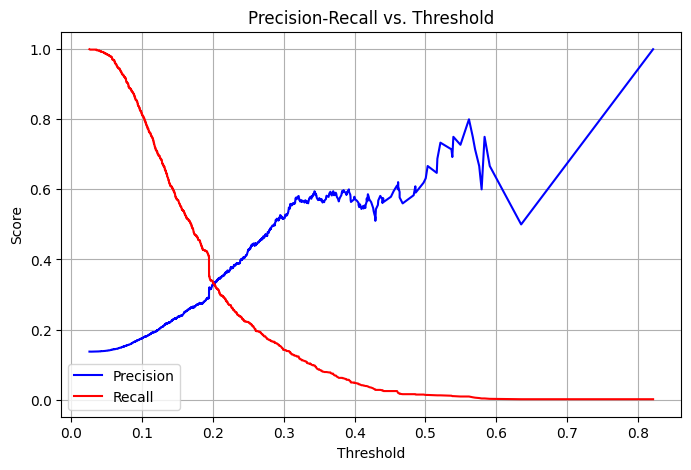

Best threshold: 0.20043613485801487
Balanced recall: 0.3325942350332594
Balanced precision: 0.33222591362126247
              precision    recall  f1-score   support

           0       0.89      0.89      0.89      5681
           1       0.33      0.33      0.33       902

    accuracy                           0.82      6583
   macro avg       0.61      0.61      0.61      6583
weighted avg       0.82      0.82      0.82      6583

[[5078  603]
 [ 602  300]]


In [ ]:
# make precsion recall curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
import numpy as np

precision, recall, thresholds = precision_recall_curve(
    y_test,
    y_prob_cls_1,
    pos_label=1
)

# Plot Precision-Recall vs. Threshold
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs. Threshold")
plt.legend()
plt.grid()
plt.show()

# intersection calculation
diff = precision[:-1] - recall[:-1]
i = np.where(np.sign(diff[:-1]) != np.sign(diff[1:]))[0][0]
best_threshold = thresholds[i]
balanced_recall = recall[i]
balanced_precision = precision[i]

print(f"Best threshold: {best_threshold}")
print(f"Balanced recall: {balanced_recall}")
print(f"Balanced precision: {balanced_precision}")

# make a report with new threshhold
y_pred_svm_cal = (y_prob_cls_1 >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_svm_cal))
print(confusion_matrix(y_test, y_pred_svm_cal))

Because this balanced threshold has not let to a significantly better model, we will stay with the previous final model for predictions as it had only 7% less precision but 18% more recall.

In [ ]:
svm_final = svm_final

print(classification_report(y_test, y_pred_svm_final))
print(confusion_matrix(y_test, y_pred_svm_final))

              precision    recall  f1-score   support

           0       0.91      0.77      0.83      5681
           1       0.26      0.51      0.34       902

    accuracy                           0.73      6583
   macro avg       0.58      0.64      0.59      6583
weighted avg       0.82      0.73      0.76      6583

[[4358 1323]
 [ 443  459]]


In [ ]:
# lets make a function that takes a tweet and predicts it based on everything
def predict_president_tweet_for_market(tweet, model=svm_final):
    # clean / lemmatise
    tweet_clean = lemmatise_series(pd.Series([tweet]))[0]

    # vectorize
    X_vec = tfidf.transform([tweet_clean])

    # predict
    if hasattr(model, "predict_proba"):
        prob  = model.predict_proba(X_vec)[:, 1][0]
        label = int(prob >= best_threshold)
        return label, prob
    else:
        label = int(model.predict(X_vec)[0])
        return label, None

In [ ]:
# lets make an example with trumps tweet and tariff anouncement
tariff_tweet = """
On Trade, I have decided, for purposes of Fairness, that I will charge a RECIPROCAL Tariff meaning, whatever Countries charge the United States of America, we will charge them - No more, no less!

For purposes of this United States Policy, we will consider Countries that use the VAT System, which is far more punitive than a Tariff, to be similar to that of a Tariff. Sending merchandise, product, or anything by any other name through another Country, for purposes of unfairly harming America, will not be accepted. In addition, we will make provision for subsidies provided by Countries in order to take Economic advantage of the United States. Likewise, provisions will be made for Nonmonetary Tariffs and Trade Barriers that some Countries charge in order to keep our product out of their domain or, if they do not even let U.S. businesses operate. We are able to accurately determine the cost of these Nonmonetary Trade Barriers. It is fair to all, no other Country can complain and, in some cases, if a Country feels that the United States would be getting too high a Tariff, all they have to do is reduce or terminate their Tariff against us. There are no Tariffs if you manufacture or build your product in the United States.

For many years, the U.S. has been treated unfairly by other Countries, both friend and foe. This System will immediately bring Fairness and Prosperity back into the previously complex and unfair System of Trade. America has helped many Countries throughout the years, at great financial cost. It is now time that these Countries remember this, and treat us fairly – A LEVEL PLAYING FIELD FOR AMERICAN WORKERS. I have instructed my Secretary of State, Secretary of Commerce, Secretary of the Treasury, and United States Trade Representative (USTR) to do all work necessary to deliver RECIPROCITY to our System of Trade!
"""
label, prob = predict_president_tweet_for_market(
    tariff_tweet,
)
print(f"Label: {label}, Prob: {prob}")

Label: 1, Prob: None


### Strengths and Limitations

Our SVM keeps the problem simple and fast because it is a straight-line (linear) model. it trains exremly fast even on hundreds of thousands of tweets. We faced some RAM limitations in Colab unfortuantately when we tried more RAM intensive or time intensive models or methods because the data is very large and the Sparse Vector Matrix by Tfidf accordingly even larger and takes a lot of computing power. By lemmatising the text and using word and phrase-based TF-IDF features we let the model “see” common policy phrases like tariff, tax cut, or trade deal. We balanced the classes and tuned the main knob C to 0.1 so the final version now spots a little more than half of all market-moving tweets (51% recall)—a big jump from the first try that caught only 17%. Because the model is linear we can also look at the top-weighted words to understand why it fires, which gives analysts an easy sanity check.
Only about one in four tweets flagged as important actually moves the market (27% precision), so an analyst would still see many false alarms. Any 1% move in the SPY index within five hours counts as significant—so the model might treat unrelated price swings as tweet effects or miss very short changes. Using just SPY means we overlook sector specific impacts, and TFIDF misses deeper context or sarcasm that a modern language model could catch. Also, our data end in 2021, so the model knows nothing about more recent presidents or todays market mood. Also perhaps tweets that happen close to each other and only one is market relevant create some noise for the model and makes it harder to see patterns for the svm model.
Overall, the tuned SVM gives us a solid model. It successfully rescues half of the truly market relevant tweets. For a human trader or news desk analyst that trade off can be worthwhile, you get fewer things to read, yet still catching most big signals. If the use case demands fewer false positives we could raise the probability threshold and if catching nearly everything is critical we could lower it and accept more noise.
But overall the model would probably not be considered extremly useful, however for a minority class like our class 1 our achieved recall and precision is not a bad result.